# Simple AutoEncoder with MNIST

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.utils as utils
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [3]:
# GPU check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load MNIST Data

In [4]:
batch_size = 128
test_batch_size = 5

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/',
                            train=True,
                            transform=transform,
                            download=True)

test_data  = datasets.MNIST(root='~/.pytorch/MNIST_data/',
                            train=False,
                            transform=transform,
                            download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader  = torch.utils.data.DataLoader(dataset=test_data,
                                           batch_size=test_batch_size,
                                           shuffle=False)

len(train_data)

60000

## Define Model

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(inplace=True),

            nn.Linear(128, 64),
            nn.ReLU(inplace=True),

            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            
            nn.Linear(32, 3)
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 32),
            nn.ReLU(inplace=True),
            
            nn.Linear(32, 64),
            nn.ReLU(inplace=True),

            nn.Linear(64, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(-1, 28*28)         # flatten
        z = self.encoder(x)
        out = self.decoder(z)
        out = out.view(-1, 28*28)
        
        return out
    
model = AutoEncoder().to(device)

In [7]:
loss = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002, weight_decay=1e-5)

## Training

In [8]:
num_epochs = 100

for epoch in range(num_epochs):
    
    total_batch = len(train_data) // batch_size
    
    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        x = batch_images.view(-1, 28 * 28).to(device)   # flatten
        
        pred = model(x)
        cost = loss(pred, x)
        
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        
        if (i+1) == total_batch:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.5f'%(epoch+1, num_epochs, i+1, total_batch, cost.item()))
            
    if (epoch + 1) % 50 == 0:
        # Save model
        torch.save(model.state_dict(), 'saved_models/SimpleAE_mnist_{:03d}.pkl'.format(epoch+1))

Epoch [1/100], lter [468/468] Loss: 0.24695
Epoch [2/100], lter [468/468] Loss: 0.21600
Epoch [3/100], lter [468/468] Loss: 0.18589
Epoch [4/100], lter [468/468] Loss: 0.18541
Epoch [5/100], lter [468/468] Loss: 0.18194
Epoch [6/100], lter [468/468] Loss: 0.16945
Epoch [7/100], lter [468/468] Loss: 0.17619
Epoch [8/100], lter [468/468] Loss: 0.16097
Epoch [9/100], lter [468/468] Loss: 0.16063
Epoch [10/100], lter [468/468] Loss: 0.14926
Epoch [11/100], lter [468/468] Loss: 0.16087
Epoch [12/100], lter [468/468] Loss: 0.15816
Epoch [13/100], lter [468/468] Loss: 0.14719
Epoch [14/100], lter [468/468] Loss: 0.15564
Epoch [15/100], lter [468/468] Loss: 0.15467
Epoch [16/100], lter [468/468] Loss: 0.14502
Epoch [17/100], lter [468/468] Loss: 0.15659
Epoch [18/100], lter [468/468] Loss: 0.14502
Epoch [19/100], lter [468/468] Loss: 0.16217
Epoch [20/100], lter [468/468] Loss: 0.14875
Epoch [21/100], lter [468/468] Loss: 0.14769
Epoch [22/100], lter [468/468] Loss: 0.13946
Epoch [23/100], lte

In [9]:
# Load weights of model
# model.load_state_dict(torch.load('saved_models/SimpleAE_mnist_100.pkl'))

## Generate images

In [10]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

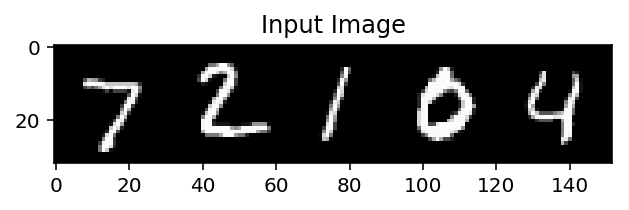

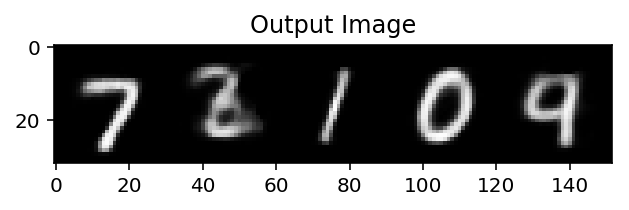

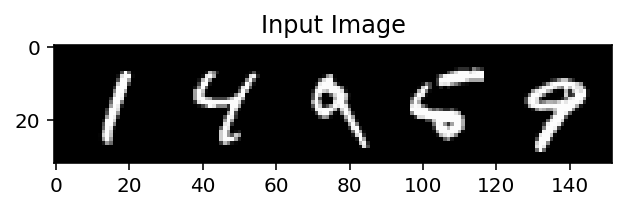

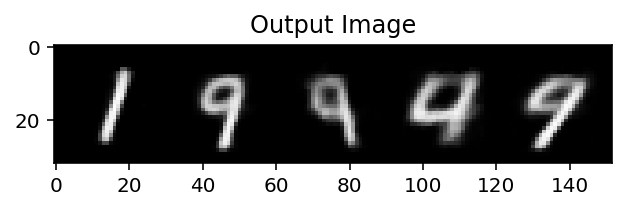

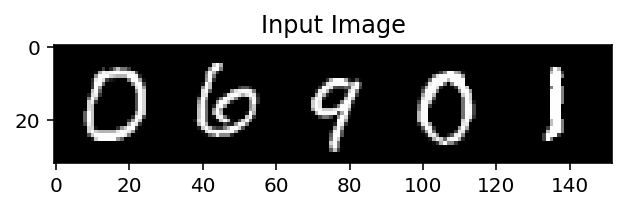

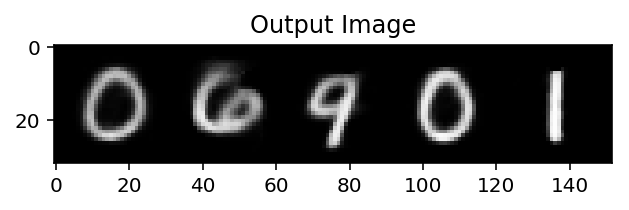

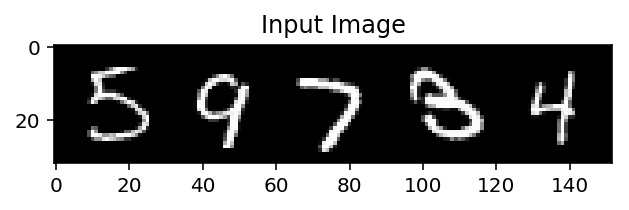

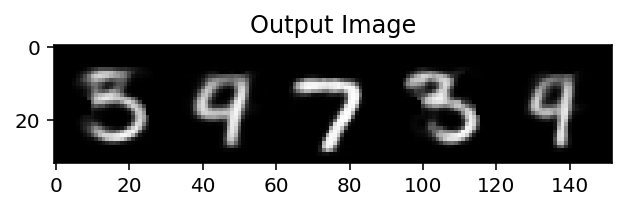

In [12]:
model.eval()

for i, (images, labels) in enumerate(test_loader):
    
    imshow(utils.make_grid(images, normalize=True), "Input Image")
    images  = images.view(-1, 28 * 28).to(device)
    
    outputs = model(images)
    outputs = outputs.view(test_batch_size, 1, 28, 28)
    
    imshow(utils.make_grid(outputs.data.cpu(), normalize=True), "Output Image")
    print('=========================================')
    
    if i > 2 : break